# Tomato Disease Prediction for AgroAI  
## Model 4: DenseNet
### Import Dependencies

In [1]:
import tensorflow as tf
from PIL import Image
import cv2, pathlib, splitfolders
from tensorflow.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import os
import shutil
import pickle
import tempfile
from sklearn.model_selection import train_test_split

In [2]:
import seaborn as sns

In [3]:
np.__version__

'1.23.5'

In [4]:
tf.__version__

'2.6.0'

In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


### Load Images

In [6]:
IMAGE_SIZE = 224
TARGET_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
CHANNELS = 3
BATCH_SIZE = 32
INPUT_SHAPE2 = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [7]:
#def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.1, test_split=0.1):
#    assert (train_split + test_split + val_split) == 1
#    
    # Only allows for equal validation and test splits
#    assert val_split == test_split 

In [8]:
# Set up the base directory
base_dir = "./AgroAI/Tomato"

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            base_dir,
            labels = 'inferred',
            shuffle = True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE,
            color_mode = 'rgb'
)

Found 9119 files belonging to 10 classes.


In [10]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [11]:
#def resize_data(images, labels):
#    tf.print('Original shape -->', tf.shape(images))
#    SIZE = (224, 224)
#    return tf.image.resize(images, SIZE), labels

In [12]:
#dataset = dataset.map(resize_data)

In [13]:
classes = dataset.class_names
classes

['Tomato Bacterial spot',
 'Tomato Early blight',
 'Tomato Late blight',
 'Tomato Leaf Mold',
 'Tomato Septoria leaf spot',
 'Tomato Spider mites Two spotted spider mite',
 'Tomato Target Spot',
 'Tomato Tomato Yellow Leaf Curl Virus',
 'Tomato Tomato mosaic virus',
 'Tomato healthy']

In [14]:
len(dataset)

285

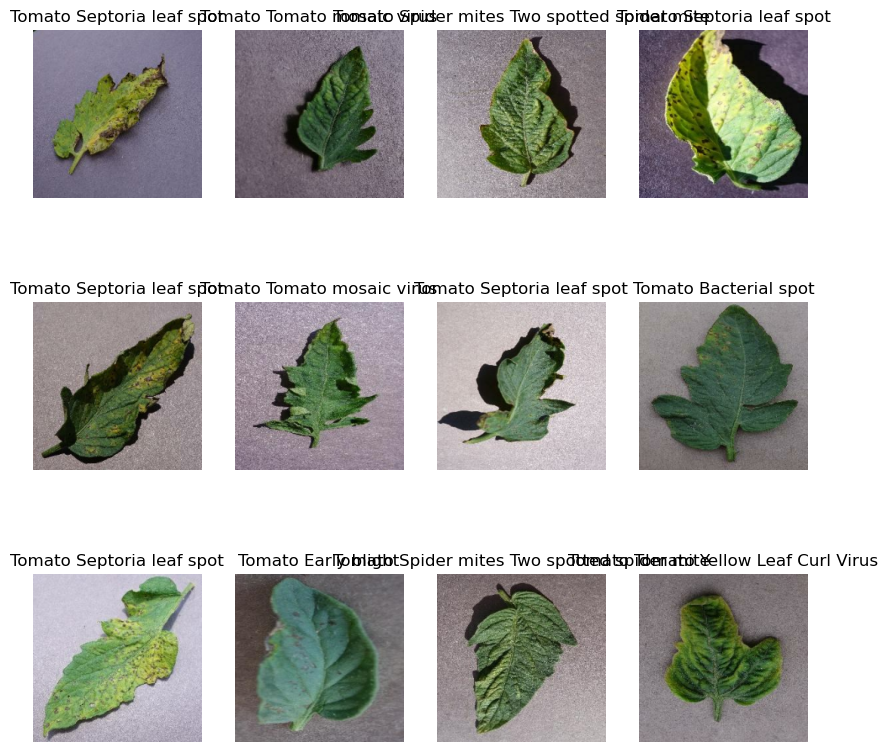

In [15]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [16]:
len(dataset) * 32

9120

### Data Splitting

In [17]:
def data_split(data, train_split = 0.8, val_split = 0.15, 
               test_split = 0.05, shuffle=True, shuffle_size = 10000):
    data_size = len(data)
    if shuffle:
        data = data.shuffle(shuffle_size, seed=8)
    
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    
    train_ds = data.take(train_size)
    val_ds = data.skip(train_size).take(val_size)
    test_ds = data.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = data_split(dataset)

In [19]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 228

Length of Validation Dataset is 42

Length of Testing Dataset is 15


### Image Augmentation

Since ImageDataGenerator is deprecated as of Tensorflow >=2.5, we can use the Keras Layers Experimental Preprocessing API to apply the image augmentations instead.

In [20]:
train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [21]:
#def preprocessing(ds):
#  for images, labels in ds:
#    images /= 255.0

#  return tf.image.resize(images,[224,224]), tf.one_hot(labels, 3)

In [22]:
#train_ds = preprocessing(train_ds)

In [23]:
#val_ds = preprocessing(val_ds)

In [24]:
#print(train_ds)

In [25]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [26]:
def resize(ds):
    resizing_rescaling = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Resizing(224,224),
        tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
    ])

    return resizing_rescaling

In [27]:
resizing_rescaling = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224,224),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
])

In [28]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, 0.3),
                                                                 width_factor=(-0.3, 0.3),
                                                                 fill_mode = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.3, 0.3),
                                                                 width_factor=(-0.3, 0.3),
                                                                 fill_mode = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(-0.3, 0.3),
                                                            interpolation = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.9)
])

    return data_augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


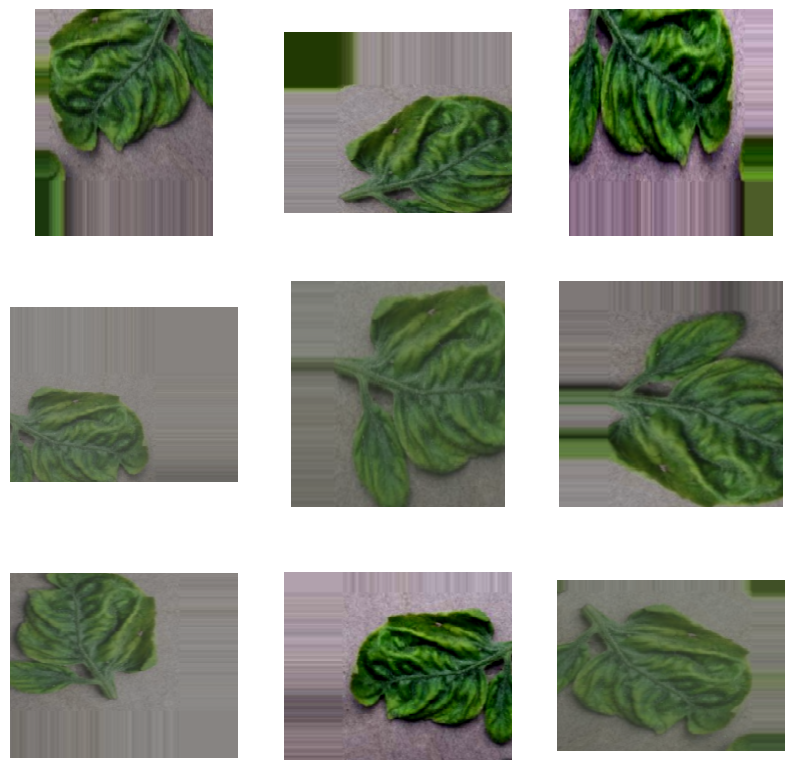

In [29]:
data_augmentation = data_augmenter()

for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [30]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, 0.3),
                                                             width_factor=(-0.3, 0.3),
                                                             fill_mode = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.3, 0.3),
                                                             width_factor=(-0.3, 0.3),
                                                             fill_mode = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(-0.3, 0.3),
                                                        interpolation = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomContrast(0.9)
])

### Init Methods

In [31]:
def conf_matrix(y_test, y_pred):
  cf_matrix = confusion_matrix(y_test, y_pred)

  ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

  ax.set_title('Confusion Matrix with labels\n')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')
  ax.set_xticks()
  ax.xaxis.set_ticklabels(source_classes, rotation=45)
  ax.yaxis.set_ticklabels(source_classes, rotation=45)

  plt.show()

In [32]:
saved_model_dir = "saved_model"
saved_model_his = "saved_model_history"
tflite_model_dir = "tflite_model"

if not(os.path.isdir(saved_model_dir)): os.mkdir(saved_model_dir)
if not(os.path.isdir(saved_model_his)): os.mkdir(saved_model_his)
if not(os.path.isdir(tflite_model_dir)): os.mkdir(tflite_model_dir)

In [33]:
# save model method
def saved_model(modelname, model):
  export_path = os.path.join(saved_model_dir, modelname)
  if os.path.isdir(export_path):
    print('\nAlready saved a model, replace to new model\n')
    shutil.rmtree(export_path, ignore_errors=True)

  model.save(export_path)
  print("Export path: ", export_path)
  print(os.listdir(export_path))

# save model history method
def saved_model_history(modelname, history):
  with open(os.path.join(saved_model_his, modelname), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [34]:
# convert saved model to TFLite model
def tflite_model_convert(modelname, tflitedir):
  # Intialize the TFLite converter to load the SavedModel
  export_path = os.path.join(saved_model_dir, modelname)

  converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

  # Set the optimization strategy in the converter 
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  # Use the tool to finally convert the model
  tflite_model = converter.convert()

  # Write TFLite model
  tflite_dir = os.path.join(tflite_model_dir, tflitedir)

  if os.path.isdir(tflite_dir):
    print('\nAlready saved a model, replace to new model\n')
    shutil.rmtree(tflite_dir, ignore_errors=True)

  os.mkdir(tflite_dir)

  tflite_file = os.path.join(tflite_dir, "leaf_{}.tflite".format(tflitedir.lower()))
  label_file = os.path.join(tflite_dir, "leaf_{}.txt".format(tflitedir.lower()))

  with open(tflite_file, "wb") as f:
      f.write(tflite_model)

  with open(label_file, 'w') as f:
      f.write('\n'.join(name_classes))

  print("Export path: ", tflite_dir)
  print(os.listdir(tflite_dir))

In [35]:
# save all model with simplify function
def save_all_model(modelname, model, history):
  # save model
  saved_model(modelname, model)

  # save history as dict
  saved_model_history(modelname, history)

  # save best model
  #best_model = tf.keras.models.load_model('best_{}.h5'.format(modelname))
  #best_modelname = "BestMC_{}".format(modelname)
  #saved_model(best_modelname, best_model)
  # clear best model h5 format
 # os.remove('best_{}.h5'.format(modelname))

  # save tflite best model
  #tflite_model_convert(best_modelname, modelname)

### Model 4: DenseNet

In [36]:
# Get a single batch from the dataset
batch = next(iter(train_ds))

input_data = batch[0]

# Print the shape of the data in the batch
print(input_data.shape)

(31, 224, 224, 3)


In [37]:
len(classes)

10

In [38]:
from tensorflow.keras.applications.densenet import DenseNet121

pre_trained_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)


pre_trained_model.trainable = False

In [39]:
preprocess_input = tf.keras.applications.densenet.preprocess_input

In [61]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
x = preprocess_input(inputs)
#x = data_augmentation(x)
#x = mbnet_v2(x, training=False)
x = pre_trained_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
predict = tf.keras.layers.Dense(10, activation = 'softmax')(x)

model4 = tf.keras.Model(inputs = inputs, outputs = predict)

In [62]:
model4.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0   

In [66]:
class EarlyStoppingAtMaxAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True
        elif(logs.get('val_accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True

callbacks = EarlyStoppingAtMaxAccuracy()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

In [67]:
model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [68]:
history4 = model4.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
    callbacks=[callbacks]
)

Epoch 1/100
228/228 [==============================] - 37s 127ms/step - loss: 0.0904 - accuracy: 0.9727 - val_loss: 0.0201 - val_accuracy: 0.9940

Accuracy is high so cancelling training!


In [83]:
model4.save('DenseNet121Model_Tomato_v2.h5')

In [84]:
modelname = "DenseNet121Model_Tomato_Save2"
save_all_model(modelname, model4, history4)

INFO:tensorflow:Assets written to: saved_model\DenseNet121Model_Tomato_Save2\assets
Export path:  saved_model\DenseNet121Model_Tomato_Save2
['assets', 'keras_metadata.pb', 'saved_model.pb', 'variables']


In [69]:
score_train = model4.evaluate(train_ds)
score_valid = model4.evaluate(val_ds)
score_test = model4.evaluate(test_ds)

15/15 [==============================] - 3s 67ms/step - loss: 0.0176 - accuracy: 0.9937


In [70]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

In [71]:
print("Accuracy: {}".format(acc[-1]))
print("Validation Accuracy: {}".format(val_acc[-1]))

print("Loss: {}".format(loss[-1]))
print("Validation Loss: {}".format(val_loss[-1]))

Accuracy: 0.9727247953414917
Validation Accuracy: 0.9940476417541504
Loss: 0.09039829671382904
Validation Loss: 0.02009337954223156


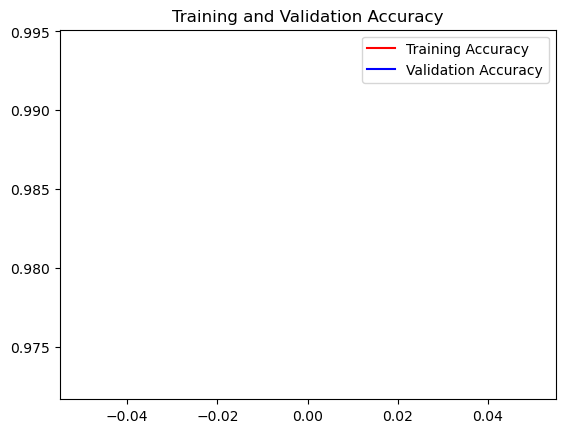

<Figure size 640x480 with 0 Axes>

In [72]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

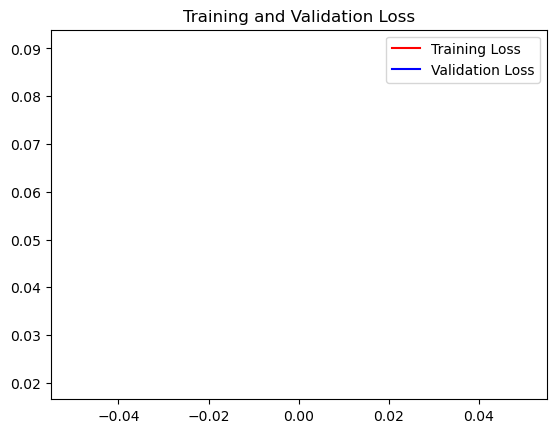

<Figure size 640x480 with 0 Axes>

In [73]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

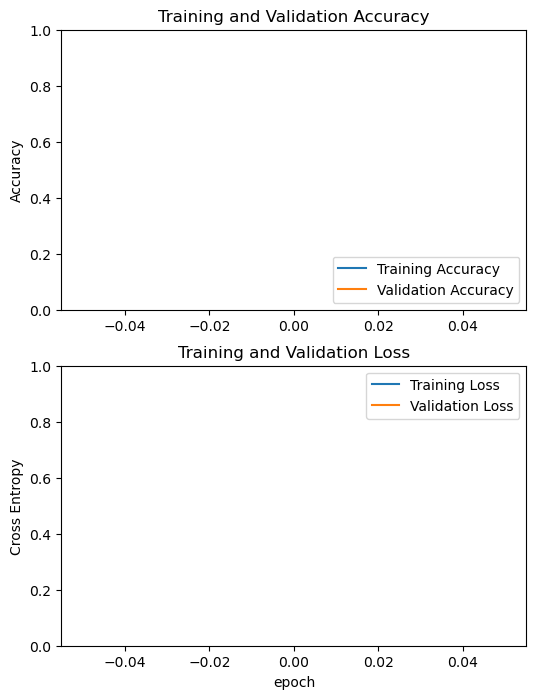

In [74]:
plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

first image to predict
actual label: Tomato Septoria leaf spot
predicted label: Tomato Septoria leaf spot


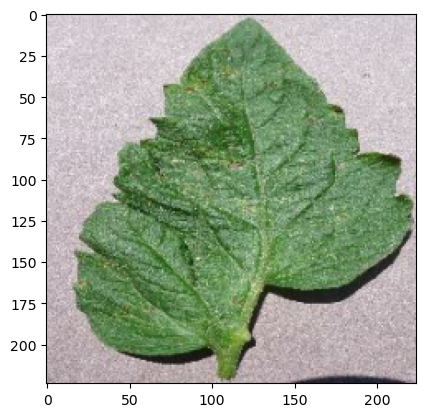

In [75]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model4.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [76]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = classes[np.argmax(predictions[0])]
#     confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

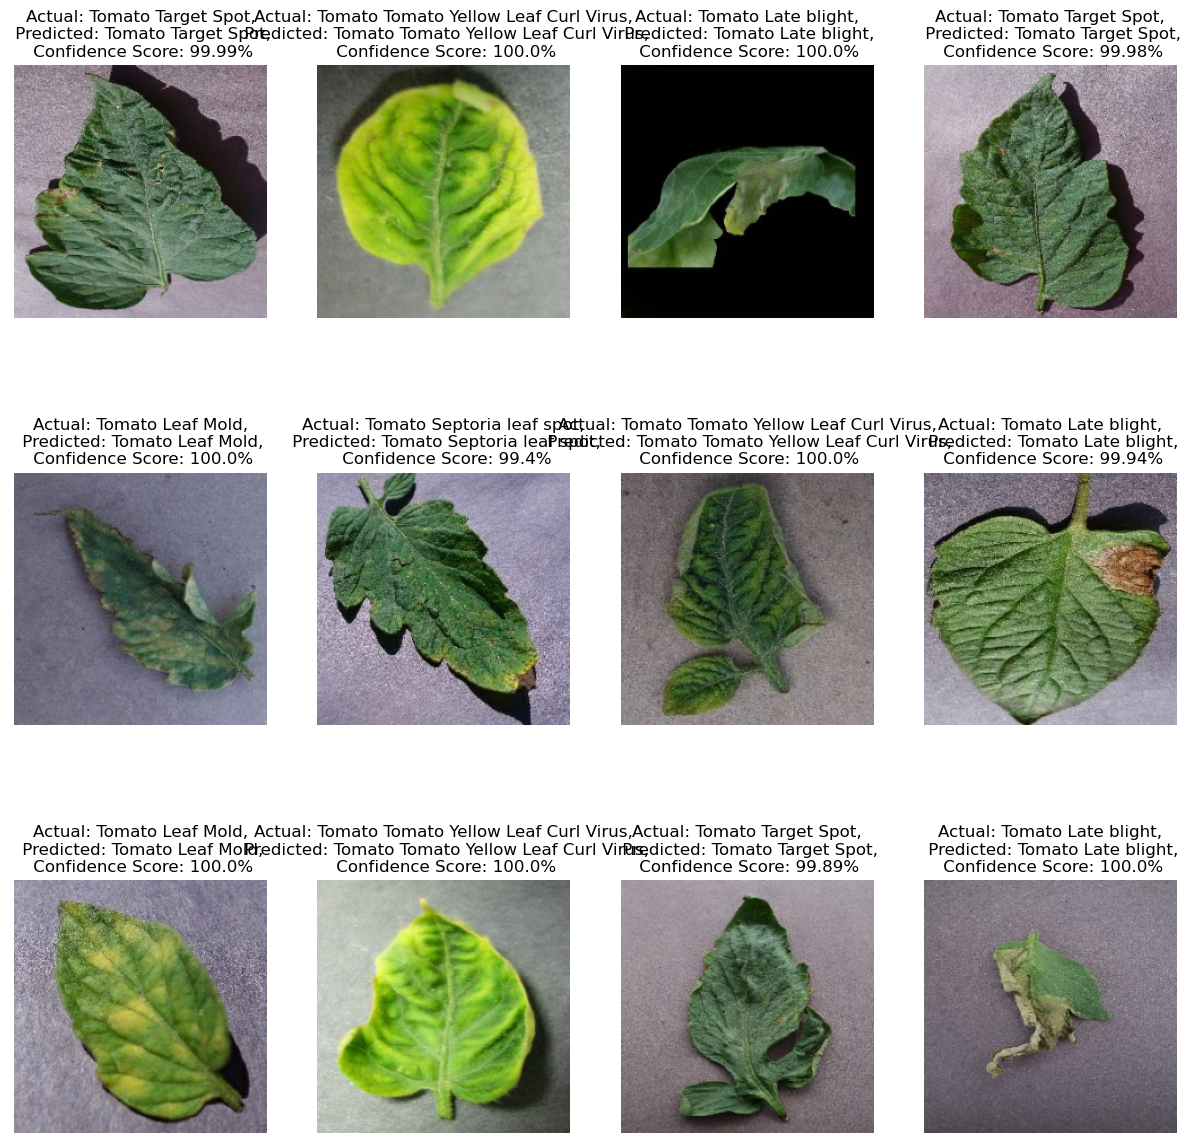

In [77]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model4,images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [78]:
pred_class = []
act_class = []
for images,labels in test_ds:
    for i in range(len(test_ds)):
        #ax = plt.subplot(3,4,i+1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model4,images[i].numpy())
        actual_class = classes[labels[i]]

        pred_class.append(predicted_class)
        act_class.append(actual_class)

In [79]:
act_class

['Tomato Tomato Yellow Leaf Curl Virus',
 'Tomato healthy',
 'Tomato Late blight',
 'Tomato healthy',
 'Tomato Septoria leaf spot',
 'Tomato Leaf Mold',
 'Tomato Tomato Yellow Leaf Curl Virus',
 'Tomato Target Spot',
 'Tomato Early blight',
 'Tomato Early blight',
 'Tomato Bacterial spot',
 'Tomato Tomato Yellow Leaf Curl Virus',
 'Tomato Tomato Yellow Leaf Curl Virus',
 'Tomato Spider mites Two spotted spider mite',
 'Tomato Spider mites Two spotted spider mite',
 'Tomato Septoria leaf spot',
 'Tomato Late blight',
 'Tomato Septoria leaf spot',
 'Tomato Spider mites Two spotted spider mite',
 'Tomato Tomato Yellow Leaf Curl Virus',
 'Tomato Late blight',
 'Tomato Early blight',
 'Tomato Leaf Mold',
 'Tomato Spider mites Two spotted spider mite',
 'Tomato Tomato mosaic virus',
 'Tomato Leaf Mold',
 'Tomato Spider mites Two spotted spider mite',
 'Tomato Spider mites Two spotted spider mite',
 'Tomato Late blight',
 'Tomato Late blight',
 'Tomato Late blight',
 'Tomato Bacterial spot',


In [80]:
cm = confusion_matrix(act_class, pred_class, labels=classes)

In [81]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(16,5))
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_title('Confusion Matrix with labels\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(classes, rotation=45)
    ax.yaxis.set_ticklabels(classes, rotation=45)

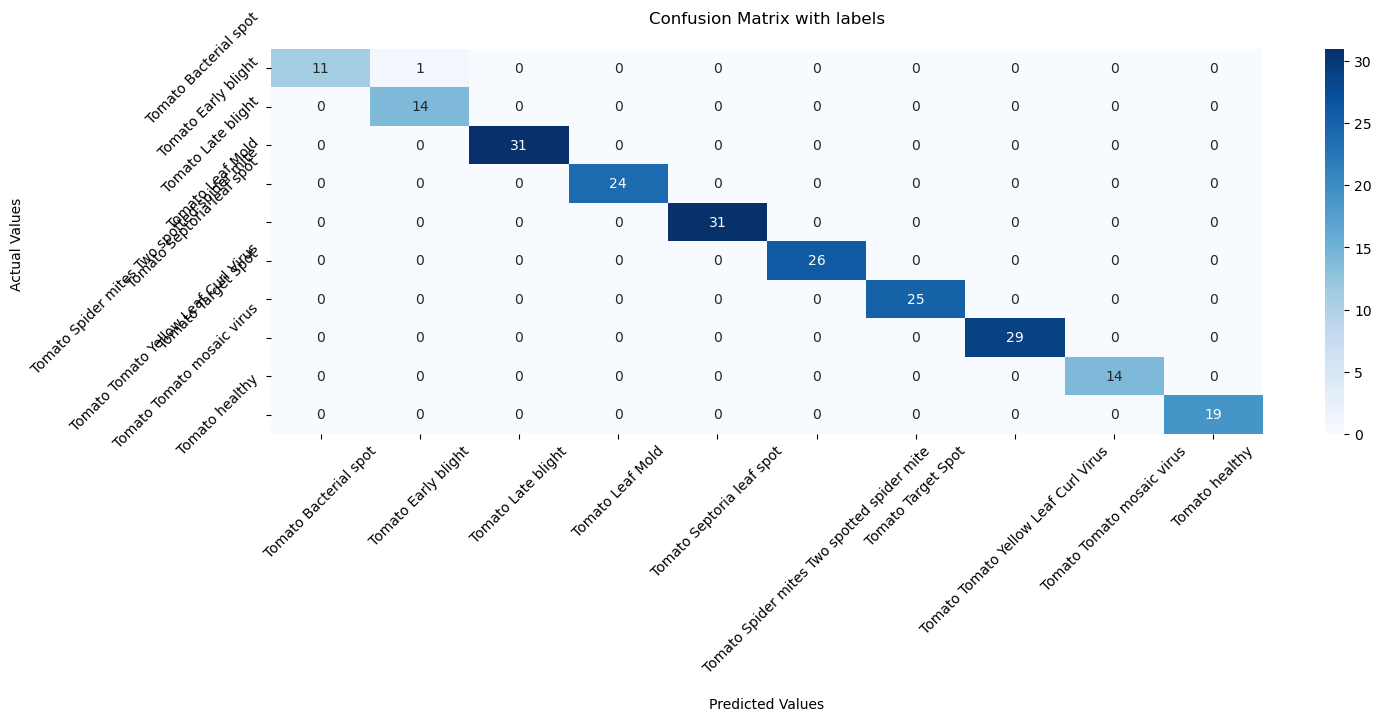

In [82]:
plot_confusion_matrix(cm = cm, classes = classes)